In [1]:
import cv2
import os
import random
from random import randint
from os import listdir
import matplotlib.pyplot as plt
from PIL import Image as PImage
from skimage import color, io
import numpy as np
import tensorflow
from numpy import asarray
from sklearn.utils import shuffle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, UpSampling2D, Input, Dense, Reshape
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import glob
import shutil
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

### Build convolutional autoencoder

In [2]:
#Defining the Autoencoder
def CAE (X_train, X_test ):  
    
    input_layer = Input(shape = (100,100,1) )   # inputs = Input(shape=(H, W, C), name="inputs")

    # Defining the encoder
    x = Conv2D(16, (3,3), activation = 'relu', padding = 'same')(input_layer)
    x= MaxPool2D(pool_size = (2,2), padding = 'same')(x)
    x= Conv2D(8, (3,3), activation = 'relu', padding = 'same')(x)

    code_layer = MaxPool2D(pool_size = (2,2), padding = 'same', name='encoder_layer')(x)

    x = Conv2D(8, (3,3), activation = 'relu', padding = 'same')(code_layer)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(16 , (3,3), activation = 'relu', padding = 'same')(x)
    x = UpSampling2D((2,2))(x)
    decoded = Conv2D(1, (3,3), activation = 'relu', padding = 'same'   )(x)   # 
   
    autoencoder = Model(input_layer, decoded)
    autoencoder.summary()
    
    opt = optimizers.Adam(learning_rate = 0.001)
    autoencoder.compile(optimizer=opt, loss='mse')   
    history = autoencoder.fit(X_train, X_train, epochs=10,  batch_size = 20, validation_data=(X_test,X_test))
    #visualise (history)

    return autoencoder

In [ ]:
# plot loss
def visualise(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()

### Display reconstruction images

In [7]:
def decoded_img(X_test, class_name, autoencoder):
    X_test= shuffle(X_test)
    decoded_images = autoencoder.predict(X_test, verbose=1)
    
    n=3
    for i in range(n):
        plt.figure(figsize =(5, 5))
        ax = plt.subplot(2, n, i + 1)
        # Display original
        plt.imshow(X_test[i].reshape(100,100,1))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_images[i].reshape(100,100,1))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
   
        # save the decoded images
        #plt.savefig(class_name+str(i)+'.png')
        plt.show()

### Features Extraction

In [4]:
def Extract_features(path, class_name, autoencoder):

    # get the encoder layers
    get_encoded_layers = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("encoder_layer").output)
    features_vector=[]
    
    # Read your input image for which you need to extract features
    for img in os.listdir(path): 
        image= cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE ) #cv2.COLOR_BGR2RGB  for color image
        image=cv2.resize(image,(100,100))
        encoded_imgs = get_encoded_layers.predict(image[None], verbose=0)[0]     
        image= encoded_imgs.reshape(-1)     
        features_vector.append(image)
        
    features_vector = np.array(features_vector)
    print('Extract local features form class {} with shape {}'. format(class_name, features_vector.shape))

    # Save your features as an numpy array    
    np.save('features_'+class_name +'.npy', features_vector)
    
    return features_vector

### K-means cluster algorithm

In [9]:
def Clustering_algorithm (X, class_Item, k_value ):
    
    """
    Function to apply K-means clustering on a dataset and create different levels
    of granularity decomposition.

    Args:
    X (numpy array): Feature representations from the latent space.
    class_Item (str): The class of images being processed.
    k_value (int): Number of clusters (k) for K-means.
    
    """
    
    # Define the path to save the results
    save_path = '.../save here'

    while k_value >1:
    
        Folder_name='g_'+str(k_value)
        path_1 = os.path.join(save_path, Folder_name)
        print('Dividing class {} into {} subclasses...'.format(class_Item, k_value))
    
        # Check if the directory exists, create it if it doesn't
        if not os.path.exists(path_1):
            os.makedirs(path_1)
        
        #Apply k_means cluster algorithm for the class 
        kmeans = KMeans(n_clusters=k_value, random_state=0).fit(X)
        #Display the number of samples in each cluster
        print('The number of samples is: ',Counter(kmeans.labels_)) 
             
        Clusters =[]
        # Create subfolders for each cluster within the current granularity folder
        for c in [i for i in range(k_value)]:
            Cluster_name = class_Item +'_'+ str(c)
            path_2 = os.path.join(path_1, Cluster_name)
            os.mkdir(path_2)
            Clusters.append(Cluster_name)        
        
        # Assign each image to its corresponding cluster label
        for img, j in zip(glob.iglob(os.path.join(src_dir,class_Item, '*.png')), kmeans.labels_):
            shutil.copy(img, path_1+'/'+ Clusters[j-1])
             
        k_value-=1     
    


### Load image dataset

read images in class: glioma
X_train shape:  (912, 100, 100, 1)
X_test shape:   (228, 100, 100, 1)
Running the convolutional autoencoder...
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 conv2d_15 (Conv2D)          (None, 100, 100, 16)      160       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 50, 50, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 50, 50, 8)         1160      
                                                                 
 encoder_layer (MaxPooling2  (None, 25, 25, 8)         0         
 D)                                                

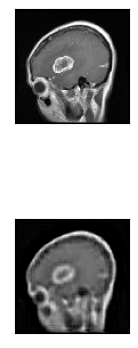

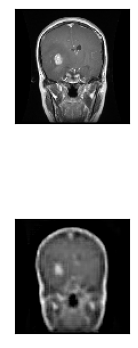

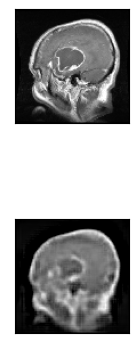

Extracting features...
Extract local features form class glioma with shape (1140, 5000)
Divide class glioma into : 5 subclasses
The number of samples is:  Counter({4: 313, 2: 229, 3: 212, 1: 193, 0: 193})
Divide class glioma into : 4 subclasses
The number of samples is:  Counter({1: 354, 2: 350, 3: 229, 0: 207})
Divide class glioma into : 3 subclasses
The number of samples is:  Counter({2: 506, 1: 393, 0: 241})
Divide class glioma into : 2 subclasses
The number of samples is:  Counter({0: 705, 1: 435})
Decomposition granularity for class "glioma" has been completed.
-----------------------------------------------------------------------------
read images in class: meningioma
X_train shape:  (452, 100, 100, 1)
X_test shape:   (113, 100, 100, 1)
Running the convolutional autoencoder...
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 100, 100, 1)]     0

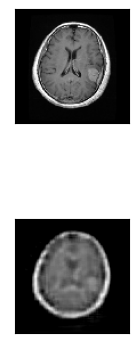

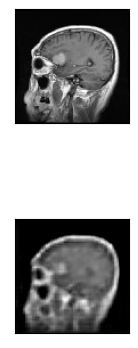

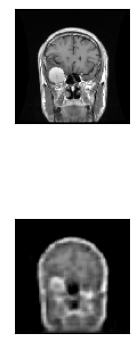

Extracting features...
Extract local features form class meningioma with shape (565, 5000)
Divide class meningioma into : 5 subclasses
The number of samples is:  Counter({4: 155, 0: 139, 2: 103, 3: 100, 1: 68})
Divide class meningioma into : 4 subclasses
The number of samples is:  Counter({1: 235, 2: 152, 0: 100, 3: 78})
Divide class meningioma into : 3 subclasses
The number of samples is:  Counter({1: 255, 0: 224, 2: 86})
Divide class meningioma into : 2 subclasses
The number of samples is:  Counter({1: 295, 0: 270})
Decomposition granularity for class "meningioma" has been completed.
-----------------------------------------------------------------------------
read images in class: pituitary tumor
X_train shape:  (595, 100, 100, 1)
X_test shape:   (149, 100, 100, 1)
Running the convolutional autoencoder...
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(

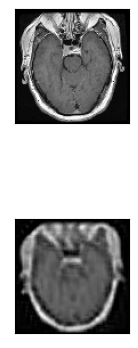

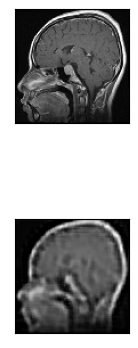

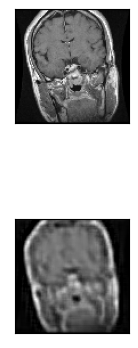

Extracting features...
Extract local features form class pituitary tumor with shape (744, 5000)
Divide class pituitary tumor into : 5 subclasses
The number of samples is:  Counter({0: 173, 4: 167, 3: 165, 2: 125, 1: 114})
Divide class pituitary tumor into : 4 subclasses
The number of samples is:  Counter({1: 223, 2: 210, 3: 174, 0: 137})
Divide class pituitary tumor into : 3 subclasses
The number of samples is:  Counter({0: 373, 1: 193, 2: 178})
Divide class pituitary tumor into : 2 subclasses
The number of samples is:  Counter({0: 450, 1: 294})
Decomposition granularity for class "pituitary tumor" has been completed.
-----------------------------------------------------------------------------


In [10]:
# Define the source directory where images are located

src_dir= ('V:/CLOG_CD/brain/train/')

Folder_dir= os.listdir(src_dir)

# determine parameter k 
k=5

for class_name in Folder_dir:
    path = os.path.join(src_dir,class_name)    
    image_list=[]

    print('read images in class:', class_name)
    for image in os.listdir(path):
        # load data set, resize it and collect it in one list
        image= cv2.imread(os.path.join(path,image),cv2.IMREAD_GRAYSCALE) #cv2.COLOR_BGR2RGB for color image
        image=cv2.resize(image,(100,100))
        image_list.append(image) 
    
    
    training_data=np.array(image_list)        #convert all data to array
    training_data= shuffle(training_data)     #shuffle data before training
    
    # Divid the data set into two groups 80% training and 20% test sets
    X_train,X_test= train_test_split(training_data, test_size =.20, shuffle  = True) 
    
    X_train = X_train.astype('float32') / 255.
    X_train = X_train.reshape(X_train.shape[0], 100,100,1)
    X_test = X_test.astype('float32') / 255.
    X_test = X_test.reshape(X_test.shape[0], 100,100,1)
    #check items in the training and testing data
    print('X_train shape: ', X_train.shape)
    print('X_test shape:  ', X_test.shape)
    
    # Run the convolutional autoencoder (CAE)
    print('Running the convolutional autoencoder...')
    autoencoder = CAE(X_train, X_test) 
    
    # Visualize the reconstructed images from the autoencoder
    decoded_img(X_test, class_name, autoencoder)  
    
    # Extract deep features from the dataset using the trained autoencoder
    print('Extracting features...')
    features_vector = Extract_features(path, class_name, autoencoder)  
       
    # Apply the clustering algorithm 
    Clustering_algorithm(features_vector, class_name, k)  
    print('Decomposition granularity for class "{}" has been completed.'.format(class_name)) 
    print('-----------------------------------------------------------------------------')